# DMRG using tensorflow


In [13]:
from __future__ import absolute_import, division, print_function
%load_ext autoreload
%autoreload 2
import tensornetwork as TN
import matrixproductstates as MPS
import matrixproductoperators as MPO
import DMRG as DMRG
import ncon
import misc_mps as mmps
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import tensorflow as tf
tf.enable_v2_behavior()
#tf.enable_eager_execution()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initializing an infinite MPS and calculating observables
Local observables (e.g. expectation values of one-site operators)
can be obtained from calling ```imps.expvals_1site(ops,sites)```.
```ops``` is a list of numpy or tensorflow matrices, for example $S^z=\left(\begin{matrix}-0.5 & 0\\ 0 & 0.5 \end{matrix}\right)$ use ```Sz=np.diag([-0.5,0.5])```

In [14]:
N,D,d=4,50,2
#create in infinite MPS in canonized form
#initializing the object for large (D > 50) will take some time; there is an sparse solver
#running in the background
dtype=tf.complex128
imps=MPS.InfiniteMPSCentralGauge.random(d=[2]*N,D=[D]*(N+1),dtype=dtype,minval=-0.5,maxval=0.5)
#the norm of the state
print('<psi|psi>={0}'.format(imps.norm().numpy()**2))
imps.position(len(imps))
print('check orthogonality conditions (all numbers should be small)')
print([imps.ortho_deviation(imps.get_tensor(n),'l').numpy() for n in range(len(imps))])
imps.position(0)
imps.position(len(imps))
print([imps.ortho_deviation(imps.get_tensor(n),'l').numpy() for n in range(len(imps))])
#change the state
shape=[imps._tensors[0].shape[0],imps._tensors[0].shape[1],imps._tensors[0].shape[2]]

imps._tensors[0]=tf.get_variable(initializer=
                                 np.random.random_sample(shape).astype(dtype.as_numpy_dtype),name='n')
#restore the canonical form
imps.restore_form()

print('==========  after changing the state  =============')
print()
print('<psi|psi>={0}'.format(imps.norm().numpy()**2))
#imps.position(len(imps))
print('check orthogonality conditions after restoring form (all numbers should be small)')
print([imps.ortho_deviation(imps.get_tensor(n),'l').numpy() for n in range(len(imps))])
imps.position(0)
imps.position(len(imps))
print([imps.ortho_deviation(imps.get_tensor(n),'l').numpy() for n in range(len(imps))])


<psi|psi>=(1.0000000000000004+0j)
check orthogonality conditions (all numbers should be small)
[(5.712579120949909e-15+0j), (5.472275030941168e-15+0j), (5.595350734381435e-15+0j), (8.444803585217734e-11+0j)]
[(5.675196771839677e-15+0j), (6.197326473542378e-15+0j), (6.5010918070416885e-15+0j), (8.444951922239015e-11+0j)]
==========  after changing the state  =============

<psi|psi>=(0.9999999999999996+0j)
check orthogonality conditions after restoring form (all numbers should be small)
[(5.493978135378963e-15+0j), (6.89446800475131e-15+0j), (5.661187635229335e-15+0j), (1.1278932840363945e-12+0j)]
[(5.181140002815766e-15+0j), (6.030217899096671e-15+0j), (6.283375852479362e-15+0j), (1.1283696470416297e-12+0j)]


In [15]:
rimps=imps.get_right_orthogonal_imps(power_method=True)
print('check orthogonality conditions (all numbers should be small)')
print([rimps.ortho_deviation(rimps.get_tensor(n),'r').numpy() for n in range(len(rimps))])
rimps.position(len(rimps))
rimps.position(0)
print([rimps.ortho_deviation(rimps.get_tensor(n),'r').numpy() for n in range(len(rimps))])

limps=imps.get_left_orthogonal_imps()
print('check orthogonality conditions (all numbers should be small)')
print([limps.ortho_deviation(limps.get_tensor(n),'l').numpy() for n in range(len(limps))])
limps.position(0)
limps.position(len(rimps))

print([limps.ortho_deviation(limps.get_tensor(n),'l').numpy() for n in range(len(limps))])



check orthogonality conditions (all numbers should be small)
[(5.028951447418385e-12+0j), (5.31777322172323e-15+0j), (4.817117742118863e-15+0j), (5.493788367075543e-15+0j)]
[(6.929646455628165+0j), (5.2287784540969925e-15+0j), (5.2870950208501045e-15+0j), (5.652494287059708e-15+0j)]
check orthogonality conditions (all numbers should be small)
[(5.302854625724801e-15+0j), (5.889981749885554e-15+0j), (5.9064260253919494e-15+0j), (4.813046505589649e-14+0j)]
[(5.6759218284589356e-15+0j), (6.242830002868975e-15+0j), (5.9588774293025176e-15+0j), (6.929646455628165+0j)]


/Users/martin/PY3_TF_1.13/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:739: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(self.numpy(), dtype=dtype)


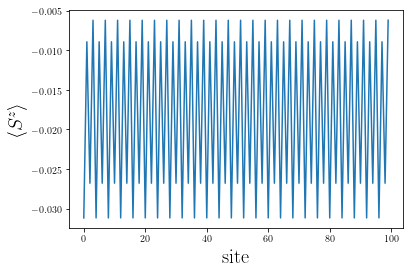

In [17]:
N,D,d=4,20,2
#create in infinite MPS in canonized form
#initializing the object for large (D > 50) will take some time; there is an sparse solver
#running in the background
imps=MPS.InfiniteMPSCentralGauge.random(d=[2]*N,D=[D]*(N+1),dtype=dtype,minval=-0.5,maxval=0.5)
#calculate expectation values <S^z[n]>
#imps.position(N)
Nmax=100 #the number of sites for which to calculate the observables
Sz=np.diag([-0.5,0.5]).astype(dtype.as_numpy_dtype)
mean_sz=imps.expvals_1site([Sz for n in range(Nmax)],range(Nmax))
plt.plot(range(Nmax),mean_sz)
plt.xlabel('site',fontsize=20)
plt.ylabel(r'$\langle S^z\rangle$',fontsize=20)
plt.draw()
plt.show()

## Some checks:
Below are some checks that an infinite MPS in canonical form should obey.

In [18]:
N,D,d=5,2,2

imps=MPS.InfiniteMPSCentralGauge.random(d=[2]*N,D=[D]*(N+1),dtype=tf.complex128,minval=-.5,maxval=1.5)
#compute left and right dominant eigen vectors of the unit-cell transfer-operator
eta1,x1=imps.TMeigs('l',numeig=1)
eta2,x2=imps.TMeigs('r',numeig=1)
print('eta1={0} (should be close to 1)'.format(eta1.numpy()))
print('eta2={0} (should be close to 1)'.format(eta2.numpy()))

#check if x1,x2 are indeed eigenvectors
print('this should be tiny:',tf.linalg.norm(imps.unitcell_transfer_op('l',x1)-x1*eta1).numpy())
print('this should be tiny:',tf.linalg.norm(imps.unitcell_transfer_op('r',x2)-x2*eta2).numpy())


eta1=(1.0000000000000764+7.765396024256296e-17j) (should be close to 1)
eta2=(1.000000000000076-1.412330476615293e-16j) (should be close to 1)
this should be tiny: (4.747810321542748e-16+0j)
this should be tiny: (5.318371745963393e-16+0j)


## Run infinite DMRG for the XXZ model

In [19]:
N,D,d=2,10,2 #systemsize, bond dimension, local hilbert space dimension
#create an Infinite MPS 
imps=MPS.InfiniteMPSCentralGauge.random(d=[2]*N,D=[D]*(N+1),dtype=dtype,minval=-0.5,maxval=0.5)
#get an MPO, e.g. for the XXZ Heisenberg model
impo=MPO.InfiniteXXZ(Jz=1.0*np.ones([N]),Jxy=np.ones([N]),Bz=np.zeros([N]),dtype=dtype)
#create an infinite DMRG-simulation 
idmrg=DMRG.InfiniteDMRGEngine(imps,impo)

#run the optimization; the energy per site E/N should be ~-0.443 for Jz=1, Jxy=1 above in MPO
idmrg.run_one_site(Nsweeps= 10,verbose=1,ncv=100)
#idmrg.mps.canonize()

SS-IDMRG  it=10/10, energy per unit-cell E/N=-0.4428200329163641+0.0000000000000000

The DMRG engine leaves imps in a non-standard form. Bring the imps back into the standard central form.

In [20]:
idmrg.run_one_site(Nsweeps= 10,verbose=1,ncv=30)


SS-IDMRG  it=10/10, energy per unit-cell E/N=-0.4429350742740397+0.0000000000000000

In [21]:
idmrg.mps.restore_form(numeig=1)

/Users/martin/PY3_TF_1.13/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


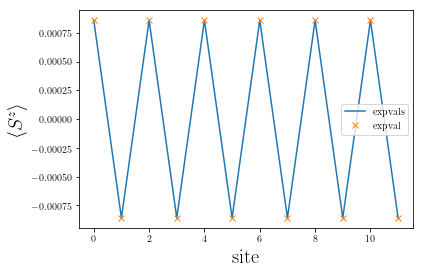

In [22]:
#calculate expectation values
L=12
imps.position(1)
Sz=np.diag([-0.5,0.5]).astype(np.complex128)

mean_sz=idmrg.mps.expvals_1site([Sz for n in range(L)],range(L))
mean_sz_=[idmrg.mps.expval_1site(Sz,n).numpy() for n in range(L)]
plt.plot(range(mean_sz.shape[0]),mean_sz.numpy(),range(len(mean_sz_)),mean_sz_,'x')
plt.xlabel('site',fontsize=20)
plt.ylabel(r'$\langle S^z\rangle$',fontsize=20)
plt.legend(['expvals','expval'])
plt.draw()
plt.show()


shift the unitcell by one site and check that state is still OK

In [23]:
idmrg.mps.cycle(1)
imps.position(1)
print('==========  after changing the state  =============')
print()
print('<psi|psi>={0}'.format(imps.norm().numpy()**2))
imps.position(len(imps))
print('check orthogonality conditions after restoring form (all numbers should be small)')
print([imps.ortho_deviation(imps.get_tensor(n),'l').numpy() for n in range(len(imps))])



==========  after changing the state  =============

<psi|psi>=(1+0j)
check orthogonality conditions after restoring form (all numbers should be small)
[(1.642587180860208e-15+0j), (2.2738612179334534e-12+0j)]


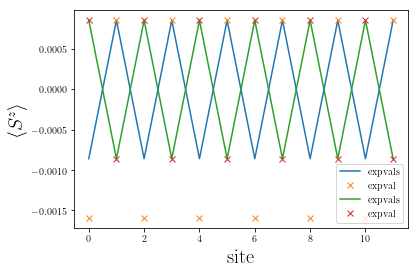

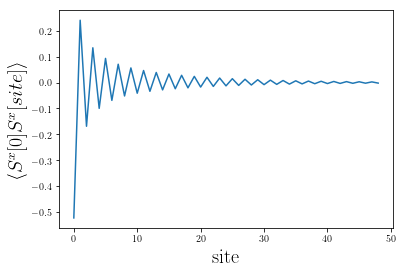

In [24]:
mean_sz_shifted=idmrg.mps.expvals_1site([Sz for n in range(L)],range(L))
mean_sz_shifted_=[idmrg.mps.expval_1site(Sz,n).numpy() for n in range(L)]
Sx=np.array([[0.0,1],[1,0]]).astype(np.complex128)

SzSz_=idmrg.mps.correlator_1site(Sx,Sx,1,50)

plt.plot(range(mean_sz_shifted.shape[0]),mean_sz_shifted.numpy(),
         range(len(mean_sz_shifted_)),mean_sz_shifted_,'x')
plt.plot(range(mean_sz.shape[0]),mean_sz.numpy(),range(len(mean_sz_)),mean_sz_,'x')
plt.legend(['expvals','expval','expvals','expval'])

plt.xlabel('site',fontsize=20)
plt.ylabel(r'$\langle S^z\rangle$',fontsize=20)
plt.draw()
plt.show()
plt.plot(SzSz_.numpy())
plt.ylabel(r'$\langle S^x[0] S^x[site]\rangle$',fontsize=20)
plt.xlabel('site',fontsize=20)

plt.draw()
plt.show()

[(2.6125018243622655+0j), (2.637606338343902+0j)]


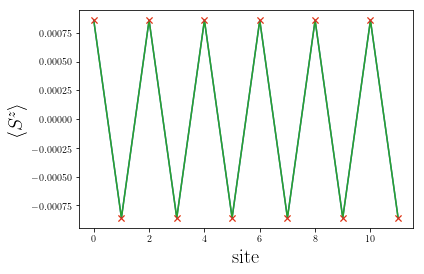

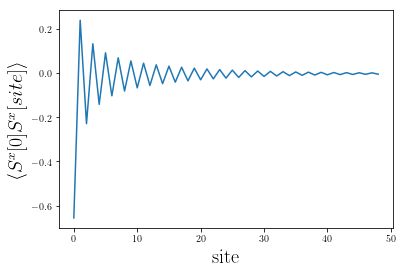

In [25]:
idmrg.mps.cycle(1)
imps.position(1)
print([imps.ortho_deviation(imps.get_tensor(n),'r').numpy() for n in range(len(imps))])
mean_sz_shifted=idmrg.mps.expvals_1site([Sz for n in range(L)],range(L))
mean_sz_shifted_=[idmrg.mps.expval_1site(Sz,n).numpy() for n in range(L)]

SzSz_=idmrg.mps.correlator_1site(Sx,Sx,1,50)

plt.plot(range(mean_sz_shifted.shape[0]),mean_sz_shifted.numpy(),
         range(len(mean_sz_shifted_)),mean_sz_shifted_,'x')
plt.plot(range(mean_sz.shape[0]),mean_sz.numpy(),range(len(mean_sz_)),mean_sz_,'x')
plt.xlabel('site',fontsize=20)
plt.ylabel(r'$\langle S^z\rangle$',fontsize=20)
plt.draw()
plt.show()

plt.plot(SzSz_.numpy())
plt.xlabel('site',fontsize=20)
plt.ylabel(r'$\langle S^x[0] S^x[site]\rangle$',fontsize=20)
plt.draw()
plt.show()

# Finite system DMRG

In [27]:
import time
N,D,d=51,100,2
mps=MPS.FiniteMPSCentralGauge.random([d]*N,[D]*(N-1),dtype=dtype)
mps.position(0)
mps.position(len(mps))
mps.position(0)
mps.normalize()
mpo=MPO.FiniteXXZ(Jz=np.ones([N-1]),Jxy=np.ones([N-1]),Bz=np.zeros([N]),dtype=dtype)
dmrg=DMRG.FiniteDMRGEngine(mps,mpo)
dmrg.run_one_site(verbose=1,Nsweeps=10,ncv=10,delta=1E-10)
    

SS-DMRG it=3/10, site=1/51: optimized E=-22.3976601829282984+0.0000000000000000 at D=4600

<tf.Tensor: id=172111, shape=(), dtype=complex128, numpy=(-22.3976601829283+0j)>

/Users/martin/PY3_TF_1.13/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:739: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(self.numpy(), dtype=dtype)


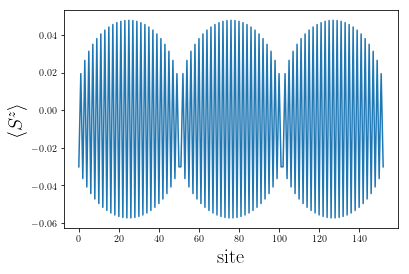

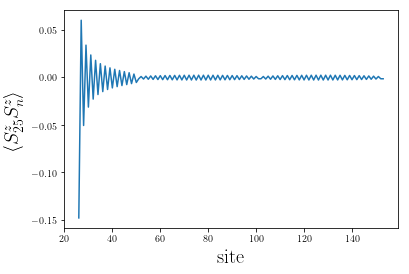

In [28]:
#calculate expectation values of z-magnetization
Sz=np.diag([-0.5,0.5]).astype(dtype.as_numpy_dtype)
Sx=np.array([[0.0,1],[1,0]]).astype(dtype.as_numpy_dtype)
mean_sz=mps.expvals_1site([Sz for n in range(3*len(mps))],range(3*len(mps)))
SzSz=dmrg.mps.correlator_1site(Sz,Sz,len(mps)//2,3*len(mps))
plt.plot(range(3*len(mps)),mean_sz)
plt.xlabel('site',fontsize=20)
plt.ylabel(r'$\langle S^z\rangle$',fontsize=20)
plt.draw()
plt.show()
plt.plot(26 + np.arange(SzSz.shape[0]),SzSz)
plt.xlabel('site',fontsize=20)
plt.ylabel(r'$\langle S^z_{25}S^z_{n}\rangle$',fontsize=20)
plt.draw()
plt.show()

In [29]:
#apply an spin-s+ operators at site 25
Sp=np.asarray([[0,1],[0,0]]).astype(dtype.as_numpy_dtype)
mps[25]=ncon.ncon([mps[25],Sp],[[-1,1,-3],[1,-2]])
mps.position(0)
mps.position(len(mps))


/Users/martin/PY3_TF_1.13/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:739: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(self.numpy(), dtype=dtype)


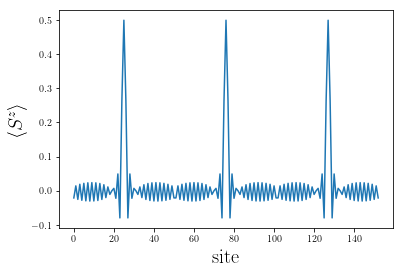

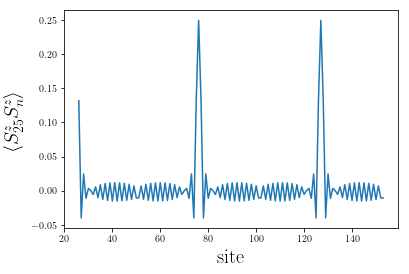

In [30]:
#calculate expectation values of z-magnetization
Sz=np.diag([-0.5,0.5]).astype(dtype.as_numpy_dtype)
Sx=np.array([[0.0,1],[1,0]]).astype(dtype.as_numpy_dtype)
mean_sz=mps.expvals_1site([Sz for n in range(3*len(mps))],range(3*len(mps)))
SzSz=dmrg.mps.correlator_1site(Sz,Sz,len(mps)//2,3*len(mps))
plt.plot(range(3*len(mps)),mean_sz)
plt.xlabel('site',fontsize=20)
plt.ylabel(r'$\langle S^z\rangle$',fontsize=20)
plt.draw()
plt.show()
plt.plot(26 + np.arange(SzSz.shape[0]),SzSz)
plt.xlabel('site',fontsize=20)
plt.ylabel(r'$\langle S^z_{25}S^z_{n}\rangle$',fontsize=20)
plt.draw()
plt.show()